YF.download() has changed argument auto_adjust default to True
Data shape: (1343, 8)

Constraint Feasibility Check:
Number of assets: 8
Minimum total weight needed: 40.0%
Maximum total weight possible: 280.0%
Transaction cost rate: 0.0002 (2.0 basis points)

Preprocessing data with GARCH and EVT...
Mean returns: [0.00089726 0.00046847 0.00094417 0.00080708 0.00060978 0.00050098
 0.00073815 0.00053961]
CVaR values: [1.52818907 1.61409754 1.51171915 1.56292463 1.51329536 1.59939526
 1.56926928 1.59270228]

EQUAL WEIGHT PORTFOLIO (CONSTRAINT-ADJUSTED):
Return: 0.1734, CVaR: 1.561449
Sharpe-like ratio: 0.11

BEST RANDOM PORTFOLIO (WITH CONSTRAINTS) - USED AS BASE PORTFOLIO:
Return: 0.1903, CVaR: 1.550958
Sharpe-like ratio: 0.12
Base portfolio weights: [0.17913951 0.06394627 0.16812544 0.1933373  0.11278253 0.05699121
 0.15398592 0.07169182]

RUNNING NSGA-II OPTIMIZATION WITH TRANSACTION COSTS...
Enhanced Weight Constraints with Transaction Costs:
  Minimum weight per asset: 5.0%
  Maximum 

C:\Users\DELL\AppData\Local\Temp\ipykernel_28544\1717239795.py:498: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


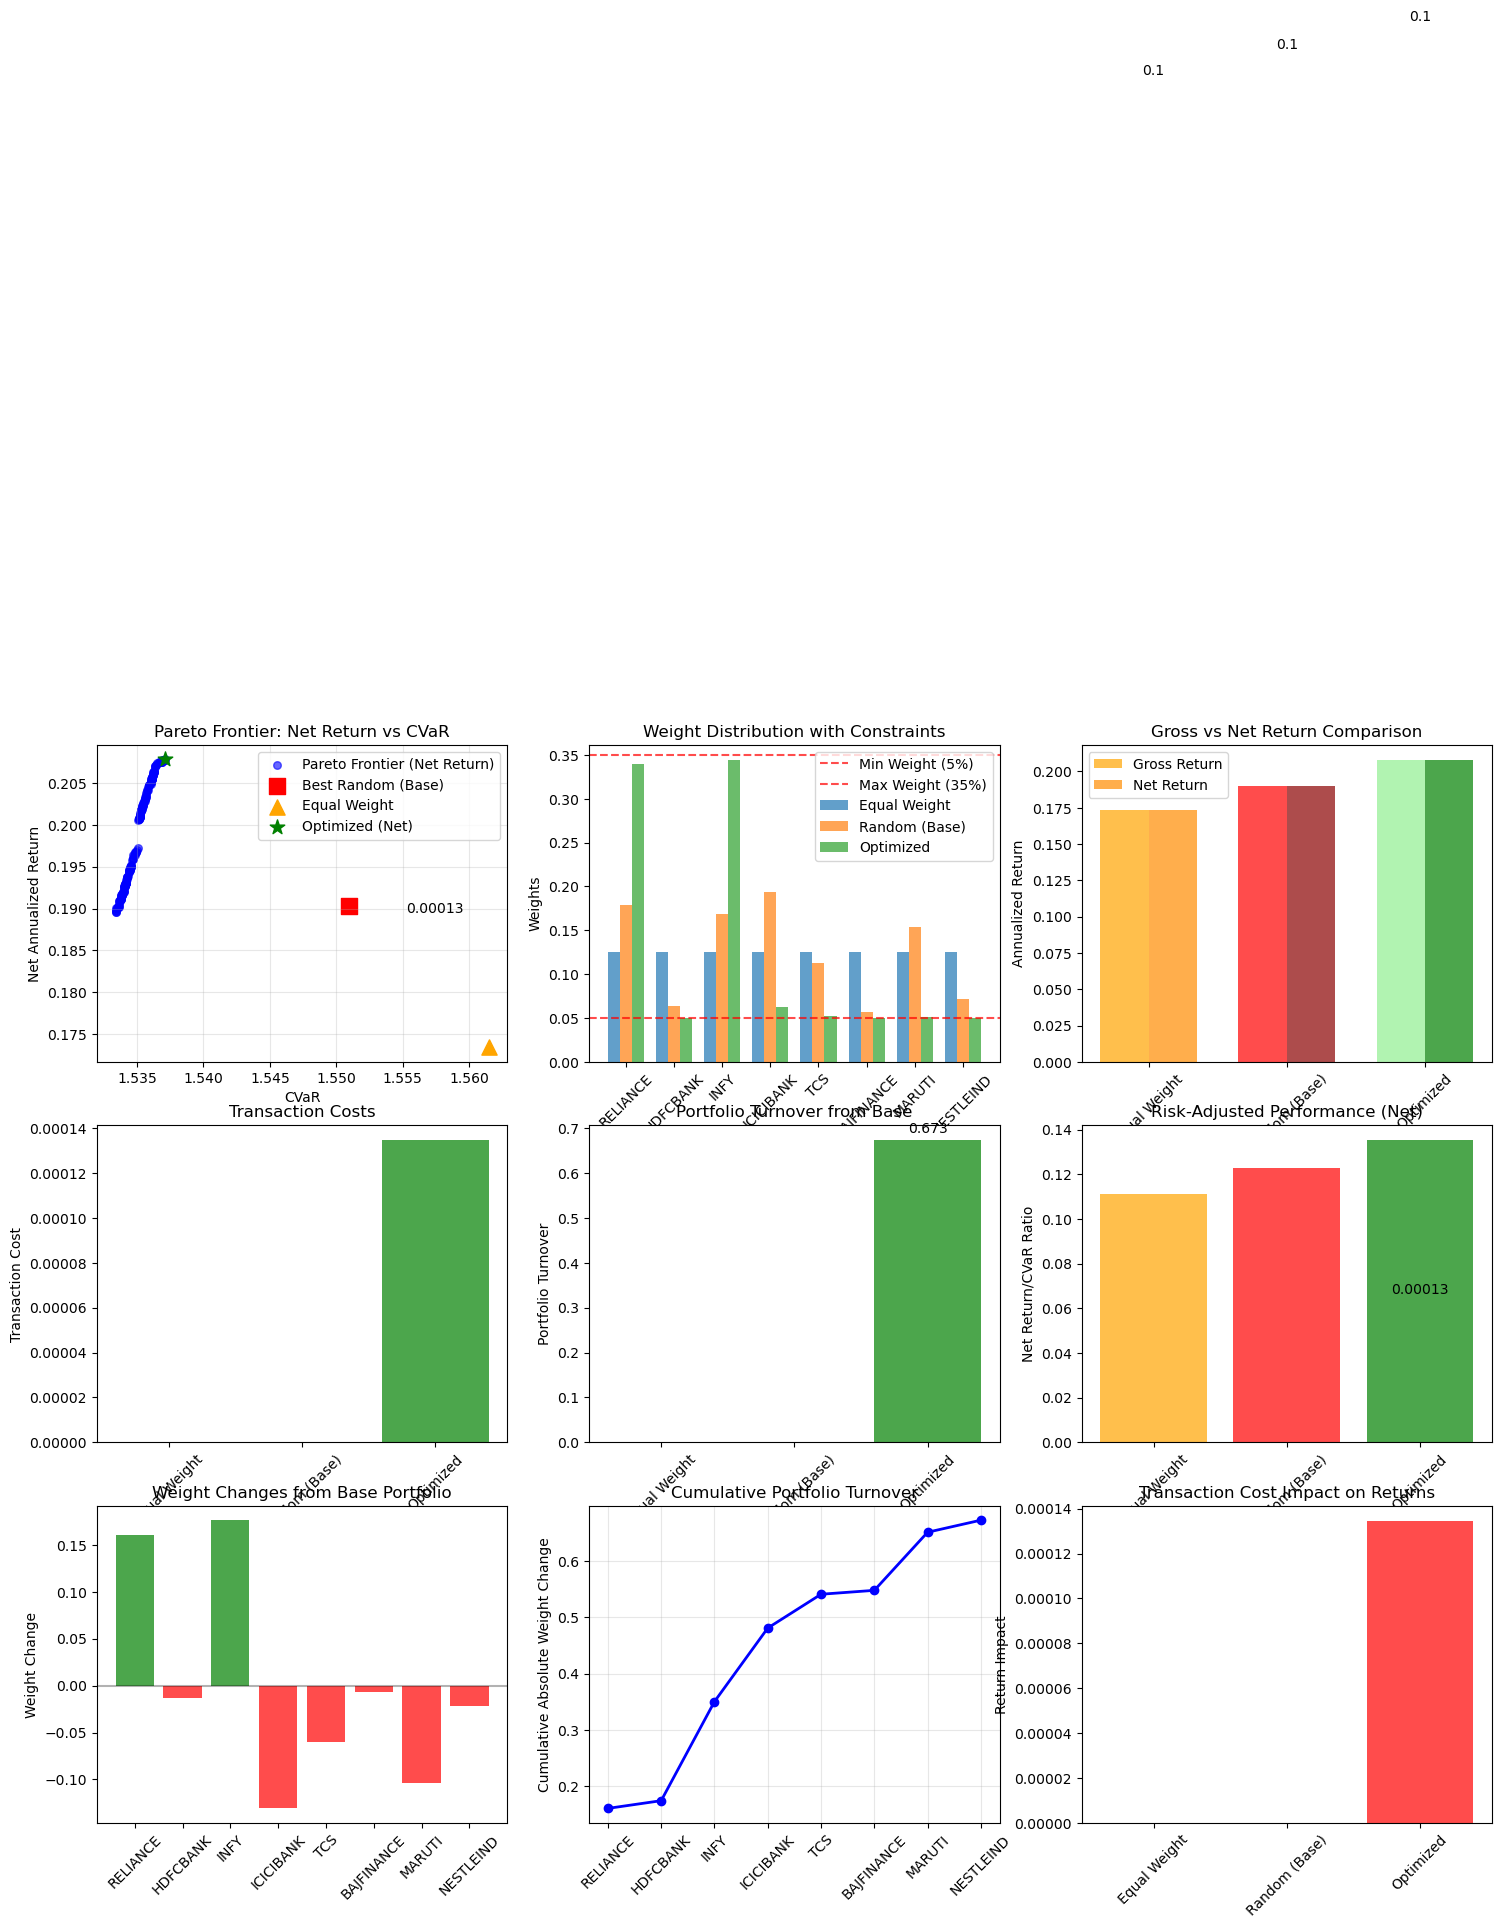

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
from arch import arch_model
from scipy.stats import genpareto
from pymoo.core.problem import ElementwiseProblem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter
import matplotlib.pyplot as plt

# Step 1: Download BSE30 stock data from Yahoo Finance
def download_stock_data(tickers, start_date="2020-01-01", end_date="2025-06-06"):
    data = yf.download(tickers, start=start_date, end=end_date, progress=False)['Close']
    returns = data.pct_change().dropna()
    return returns

# Step 2: Preprocess data with ARCH/GARCH and EVT
def preprocess_data(returns, n_bootstrap=1000):
    means = []
    cvar_values = []
    
    for stock in returns.columns:
        try:
            # Fit GARCH(1,1) model
            model = arch_model(returns[stock]*100, vol='Garch', p=1, q=1, dist='t')  # Scale for better convergence
            garch_fit = model.fit(disp='off', show_warning=False)
            
            # Extract standardized residuals for EVT
            residuals = garch_fit.std_resid.dropna()
            threshold = np.percentile(residuals, 95)  # 95th percentile for tail
            tail_data = residuals[residuals > threshold] - threshold
            
            if len(tail_data) > 10:  # Ensure enough data for GPD fit
                try:
                    params = genpareto.fit(tail_data, floc=0)
                    # Calculate CVaR using GPD parameters
                    cvar = threshold + (params[1] / (1 - params[0])) * ((0.05 ** (-params[0])) - 1)
                except:
                    cvar = np.percentile(residuals, 97.5)  # Fallback
            else:
                cvar = np.percentile(residuals, 97.5)  # Fallback to empirical CVaR
        except:
            # If GARCH fails, use simple approach
            cvar = -np.percentile(returns[stock], 5)  # 5% VaR as proxy for CVaR
        
        # Bootstrap mean returns
        bootstrap_means = []
        for _ in range(n_bootstrap):
            sample = np.random.choice(returns[stock], size=len(returns[stock]), replace=True)
            bootstrap_means.append(np.mean(sample))
        
        means.append(np.mean(bootstrap_means))
        cvar_values.append(abs(cvar))  # Ensure positive CVaR values
    
    cov_matrix = returns.cov() * 252  # Annualized covariance
    return np.array(means), cov_matrix.values, np.array(cvar_values)

# Step 3: Define MORBPO Model-II Problem with Transaction Costs
class MORBPO_Model2_WithTransactionCosts(ElementwiseProblem):
    def __init__(self, means, cov_matrix, cvar_values, base_portfolio, transaction_cost_rate=0.0002, 
                 beta1=0.95, beta2=0.95, alpha=0.95, diversification_type='mixed'):
        """
        Enhanced version with transaction costs and strict weight constraints:
        - All weights must be non-zero
        - Minimum weight: 5% per asset
        - Maximum weight: 35% per asset
        - Transaction costs based on portfolio changes from base portfolio
        """
        # Set bounds to enforce minimum and maximum weights
        min_weight = 0.05  # 5% minimum
        max_weight = 0.35  # 35% maximum
        
        super().__init__(n_var=len(means), n_obj=2, n_constr=4, 
                        xl=min_weight, xu=max_weight)  # Set bounds directly
        
        self.means = means
        self.cov_matrix = cov_matrix
        self.cvar_values = cvar_values
        self.base_portfolio = base_portfolio  # Base portfolio for transaction cost calculation
        self.transaction_cost_rate = transaction_cost_rate  # 2 basis points = 0.0002
        self.beta1 = beta1
        self.beta2 = beta2
        self.alpha = alpha
        self.n_assets = len(means)
        self.diversification_type = diversification_type
        
        # Weight constraints
        self.min_weight = min_weight
        self.max_weight = max_weight
        
        # Diversification parameters (adjusted for new constraints)
        self.min_entropy = 0.8 * np.log(self.n_assets)  # Minimum entropy threshold
        
        # Set reasonable thresholds
        self.risk_star = np.percentile(cvar_values, 75)  # 75th percentile as risk threshold
        self.return_star = np.mean(means) * 252 * 0.5  # 50% of annualized mean return
        
        print(f"Enhanced Weight Constraints with Transaction Costs:")
        print(f"  Minimum weight per asset: {self.min_weight:.1%}")
        print(f"  Maximum weight per asset: {self.max_weight:.1%}")
        print(f"  Transaction cost rate: {self.transaction_cost_rate:.4f} ({self.transaction_cost_rate*10000:.1f} basis points)")
        print(f"  Base portfolio weights: {self.base_portfolio}")
        print(f"Risk threshold: {self.risk_star:.6f}")
        print(f"Return threshold: {self.return_star:.6f}")
        print(f"Diversification type: {self.diversification_type}")
    
    def _calculate_transaction_cost(self, w):
        """Calculate transaction cost based on portfolio changes from base portfolio"""
        # Transaction cost = sum of absolute differences * cost rate
        # Using L1 norm (Manhattan distance) as in the formula
        transaction_cost = self.transaction_cost_rate * np.sum(np.abs(w - self.base_portfolio))
        return transaction_cost
    
    def _calculate_entropy(self, w):
        """Calculate portfolio entropy (Shannon entropy)"""
        # Since all weights are guaranteed to be >= min_weight > 0, no need for epsilon
        entropy = -np.sum(w * np.log(w))
        return entropy
    
    def _calculate_herfindahl_index(self, w):
        """Calculate Herfindahl-Hirschman Index (concentration measure)"""
        return np.sum(w**2)
    
    def _evaluate(self, w, out, *args, **kwargs):
        # Normalize weights to sum to 1 while maintaining bounds
        w_sum = np.sum(w)
        if w_sum <= 1e-8:
            # If sum is too small, redistribute equally within bounds
            w = np.full(len(w), 1.0 / len(w))
        else:
            w = w / w_sum
        
        # Ensure weights still respect bounds after normalization
        w = np.clip(w, self.min_weight, self.max_weight)
        w = w / np.sum(w)  # Renormalize
        
        # Calculate transaction cost
        transaction_cost = self._calculate_transaction_cost(w)
        
        # Objective 1: Maximize return minus transaction costs (minimize negative net return)
        gross_return = np.sum(self.means * w) * 252  # Annualized gross return
        net_return = gross_return - transaction_cost  # Net return after transaction costs
        
        # Objective 2: Minimize CVaR (unchanged)
        portfolio_cvar = np.sum(self.cvar_values * w)
        
        # Constraints
        constraints = []
        
        # 1. Sum of weights = 1 (equality constraint)
        g1 = abs(1.0 - np.sum(w))
        constraints.append(g1)
        
        # 2. All weights must be >= minimum weight (should be satisfied by bounds)
        min_weight_violation = self.min_weight - np.min(w)
        g2 = max(0, min_weight_violation)
        constraints.append(g2)
        
        # 3. All weights must be <= maximum weight (should be satisfied by bounds)
        max_weight_violation = np.max(w) - self.max_weight
        g3 = max(0, max_weight_violation)
        constraints.append(g3)
        
        # 4. Entropy constraint (ensure diversification within the weight constraints)
        entropy = self._calculate_entropy(w)
        entropy_violation = self.min_entropy - entropy
        g4 = max(0, entropy_violation)
        constraints.append(g4)
        
        # Set objectives (minimize both negative net return and CVaR)
        out["F"] = [-net_return, portfolio_cvar]  # Negative net return for maximization
        out["G"] = constraints

# Step 4: Random Weights Portfolio (Updated to respect constraints)
def random_portfolio(means, cvar_values, min_weight=0.05, max_weight=0.35, n_samples=1000):
    portfolios = []
    
    for _ in range(n_samples):
        # Generate random weights within bounds
        w = np.random.uniform(min_weight, max_weight, len(means))
        w = w / np.sum(w)  # Normalize
        
        # Ensure bounds are still respected after normalization
        w = np.clip(w, min_weight, max_weight)
        w = w / np.sum(w)  # Renormalize
        
        # Check if weights are valid (all within bounds)
        if np.all(w >= min_weight) and np.all(w <= max_weight):
            portfolio_return = np.sum(means * w) * 252
            portfolio_cvar = np.sum(cvar_values * w)
            portfolios.append((w, portfolio_return, portfolio_cvar))
    
    if not portfolios:
        # Fallback: create a simple valid portfolio
        w = np.full(len(means), 1.0 / len(means))
        # Adjust if equal weights violate constraints
        if 1.0 / len(means) < min_weight:
            # If equal weights are below minimum, we need fewer assets
            # This is a constraint satisfaction issue - for now, use minimum allowed
            w = np.full(len(means), min_weight)
            w = w / np.sum(w)
        elif 1.0 / len(means) > max_weight:
            # If equal weights are above maximum, adjust
            w = np.full(len(means), max_weight)
            w = w / np.sum(w)
        
        portfolio_return = np.sum(means * w) * 252
        portfolio_cvar = np.sum(cvar_values * w)
        portfolios.append((w, portfolio_return, portfolio_cvar))
    
    # Sort by Sharpe-like ratio (return/cvar)
    portfolios.sort(key=lambda x: x[1]/x[2] if x[2] > 0 else 0, reverse=True)
    
    return portfolios[0]  # Return best portfolio

def equal_weight_portfolio(means, cvar_values, min_weight=0.05, max_weight=0.35):
    """Create equal weight portfolio respecting constraints"""
    n_assets = len(means)
    equal_w = 1.0 / n_assets
    
    # Check if equal weights violate constraints
    if equal_w < min_weight:
        print(f"Warning: Equal weights ({equal_w:.1%}) below minimum ({min_weight:.1%})")
        # Use minimum weight for all assets
        w = np.full(n_assets, min_weight)
        w = w / np.sum(w)
    elif equal_w > max_weight:
        print(f"Warning: Equal weights ({equal_w:.1%}) above maximum ({max_weight:.1%})")
        # Use maximum weight for all assets
        w = np.full(n_assets, max_weight)
        w = w / np.sum(w)
    else:
        w = np.full(n_assets, equal_w)
    
    portfolio_return = np.sum(means * w) * 252
    portfolio_cvar = np.sum(cvar_values * w)
    return w, portfolio_return, portfolio_cvar

# Step 8: Main Execution
if __name__ == "__main__":
    # Define BSE30 tickers (subset available on Yahoo Finance)
    tickers = ['RELIANCE.NS', 'HDFCBANK.NS', 'INFY.NS', 'ICICIBANK.NS', 'TCS.NS',
               'BAJFINANCE.NS', 'MARUTI.NS', 'NESTLEIND.NS']
    
    print("Downloading stock data...")
    returns = download_stock_data(tickers)
    print(f"Data shape: {returns.shape}")
    
    # Check if we have enough assets for the weight constraints
    n_assets = len(tickers)
    min_weight = 0.05
    max_weight = 0.35
    transaction_cost_rate = 0.0002  # 2 basis points
    
    print(f"\nConstraint Feasibility Check:")
    print(f"Number of assets: {n_assets}")
    print(f"Minimum total weight needed: {n_assets * min_weight:.1%}")
    print(f"Maximum total weight possible: {n_assets * max_weight:.1%}")
    print(f"Transaction cost rate: {transaction_cost_rate:.4f} ({transaction_cost_rate*10000:.1f} basis points)")
    
    if n_assets * min_weight > 1.0:
        print("ERROR: Minimum weight constraint cannot be satisfied!")
        print(f"With {n_assets} assets and {min_weight:.1%} minimum each, need {n_assets * min_weight:.1%} total weight")
        exit(1)
    
    # Preprocess data
    print("\nPreprocessing data with GARCH and EVT...")
    means, cov_matrix, cvar_values = preprocess_data(returns)
    
    print(f"Mean returns: {means}")
    print(f"CVaR values: {cvar_values}")
    
    # Equal weight portfolio (adjusted for constraints)
    eq_weights, eq_return, eq_cvar = equal_weight_portfolio(means, cvar_values, min_weight, max_weight)
    print("\n" + "="*50)
    print("EQUAL WEIGHT PORTFOLIO (CONSTRAINT-ADJUSTED):")
    print(f"Return: {eq_return:.4f}, CVaR: {eq_cvar:.6f}")
    print(f"Sharpe-like ratio: {eq_return/eq_cvar:.2f}")
    
    # Random portfolio (respecting constraints) - This will be our BASE PORTFOLIO
    rand_weights, rand_return, rand_cvar = random_portfolio(means, cvar_values, min_weight, max_weight)
    print("\n" + "="*50)
    print("BEST RANDOM PORTFOLIO (WITH CONSTRAINTS) - USED AS BASE PORTFOLIO:")
    print(f"Return: {rand_return:.4f}, CVaR: {rand_cvar:.6f}")
    print(f"Sharpe-like ratio: {rand_return/rand_cvar:.2f}")
    print("Base portfolio weights:", rand_weights)
    
    # Define and solve Model-II with enhanced weight constraints and transaction costs
    print("\n" + "="*50)
    print("RUNNING NSGA-II OPTIMIZATION WITH TRANSACTION COSTS...")
    problem = MORBPO_Model2_WithTransactionCosts(
        means, cov_matrix, cvar_values, rand_weights, 
        transaction_cost_rate=transaction_cost_rate,
        beta1=0.95, beta2=0.95, alpha=0.95
    )
    algorithm = NSGA2(pop_size=300, n_offsprings=150)  # Increased population for constraint handling
    
    res = minimize(problem, algorithm, ('n_gen', 400), verbose=True, seed=42)
    
    # Extract optimized results
    opt_weights = res.X
    opt_net_returns = -res.F[:, 0]  # Convert back to positive net returns
    opt_cvars = res.F[:, 1]
    
    # Check constraint violations
    constraint_violations = res.G
    feasible_mask = (constraint_violations <= 1e-6).all(axis=1)  # Feasible solutions
    
    print(f"Total solutions: {len(opt_weights)}")
    print(f"Feasible solutions: {np.sum(feasible_mask)}")
    
    if np.any(feasible_mask):
        # Filter feasible solutions
        opt_weights = opt_weights[feasible_mask]
        opt_net_returns = opt_net_returns[feasible_mask]
        opt_cvars = opt_cvars[feasible_mask]
        
        # Additional validation: check weight constraints explicitly
        valid_solutions = []
        for i, w in enumerate(opt_weights):
            w_normalized = w / np.sum(w)
            if (np.all(w_normalized >= min_weight - 1e-6) and 
                np.all(w_normalized <= max_weight + 1e-6) and
                opt_net_returns[i] > 0 and opt_cvars[i] > 0):
                valid_solutions.append(i)
        
        if valid_solutions:
            # Filter to valid solutions
            valid_indices = np.array(valid_solutions)
            opt_weights = opt_weights[valid_indices]
            opt_net_returns = opt_net_returns[valid_indices]
            opt_cvars = opt_cvars[valid_indices]
            
            # Select portfolio with maximum Sharpe-like ratio
            sharpe_ratios = opt_net_returns / opt_cvars
            best_idx = np.argmax(sharpe_ratios)
            best_opt_weights = opt_weights[best_idx]
            best_opt_weights = best_opt_weights / np.sum(best_opt_weights)  # Normalize
            best_opt_net_return = opt_net_returns[best_idx]
            best_opt_cvar = opt_cvars[best_idx]
            
            # Calculate transaction cost and gross return for the best portfolio
            best_transaction_cost = transaction_cost_rate * np.sum(np.abs(best_opt_weights - rand_weights))
            best_opt_gross_return = best_opt_net_return + best_transaction_cost
            
            print("\n" + "="*50)
            print("OPTIMIZED PORTFOLIO WITH TRANSACTION COSTS:")
            print(f"Gross Return: {best_opt_gross_return:.4f}")
            print(f"Transaction Cost: {best_transaction_cost:.6f}")
            print(f"Net Return: {best_opt_net_return:.4f}")
            print(f"CVaR: {best_opt_cvar:.6f}")
            print(f"Sharpe-like ratio (Net Return/CVaR): {best_opt_net_return/best_opt_cvar:.2f}")
            
            # Calculate portfolio turnover
            portfolio_turnover = np.sum(np.abs(best_opt_weights - rand_weights))
            print(f"Portfolio Turnover: {portfolio_turnover:.4f} ({portfolio_turnover*100:.2f}%)")
            
            # Verify constraints
            print(f"\nWeight Constraint Verification:")
            print(f"  All weights >= {min_weight:.1%}: {np.all(best_opt_weights >= min_weight)}")
            print(f"  All weights <= {max_weight:.1%}: {np.all(best_opt_weights <= max_weight)}")
            print(f"  Sum of weights: {np.sum(best_opt_weights):.6f}")
            
            # Display weights comparison
            print("\nStock Weights Comparison:")
            print(f"{'Stock':<12} {'Base (Random)':<15} {'Optimized':<15} {'Change':<15}")
            print("-" * 60)
            for i, ticker in enumerate(tickers):
                change = best_opt_weights[i] - rand_weights[i]
                print(f"{ticker.replace('.NS', ''):<12} {rand_weights[i]:>14.1%} {best_opt_weights[i]:>14.1%} {change:>+14.1%}")
            
            # Create comprehensive comparison including transaction costs
            print("\n" + "="*80)
            print("COMPREHENSIVE COMPARISON (INCLUDING TRANSACTION COSTS):")
            print(f"{'Metric':<25} {'Equal Weight':<15} {'Random (Base)':<15} {'Optimized':<15}")
            print("-" * 80)
            print(f"{'Gross Return':<25} {eq_return:<15.4f} {rand_return:<15.4f} {best_opt_gross_return:<15.4f}")
            print(f"{'Transaction Cost':<25} {'0.0000':<15} {'0.0000':<15} {best_transaction_cost:<15.6f}")
            print(f"{'Net Return':<25} {eq_return:<15.4f} {rand_return:<15.4f} {best_opt_net_return:<15.4f}")
            print(f"{'CVaR':<25} {eq_cvar:<15.6f} {rand_cvar:<15.6f} {best_opt_cvar:<15.6f}")
            print(f"{'Sharpe Ratio (Net/CVaR)':<25} {eq_return/eq_cvar:<15.2f} {rand_return/rand_cvar:<15.2f} {best_opt_net_return/best_opt_cvar:<15.2f}")
            print(f"{'Portfolio Turnover':<25} {'N/A':<15} {'0.0000':<15} {portfolio_turnover:<15.4f}")
            
            # Plot comprehensive analysis including transaction costs
            plt.figure(figsize=(18, 14))
            
            # Pareto frontier with transaction costs
            plt.subplot(3, 3, 1)
            plt.scatter(opt_cvars, opt_net_returns, c='blue', alpha=0.6, label='Pareto Frontier (Net Return)', s=30)
            plt.scatter(rand_cvar, rand_return, c='red', s=120, label='Best Random (Base)', marker='s')
            plt.scatter(eq_cvar, eq_return, c='orange', s=120, label='Equal Weight', marker='^')
            plt.scatter(best_opt_cvar, best_opt_net_return, c='green', s=120, label='Optimized (Net)', marker='*')
            plt.xlabel('CVaR')
            plt.ylabel('Net Annualized Return')
            plt.title('Pareto Frontier: Net Return vs CVaR')
            plt.legend()
            plt.grid(True, alpha=0.3)
            
            # Weight distribution
            plt.subplot(3, 3, 2)
            x = np.arange(len(tickers))
            width = 0.25
            plt.bar(x - width, eq_weights, width, alpha=0.7, label='Equal Weight')
            plt.bar(x, rand_weights, width, alpha=0.7, label='Random (Base)')
            plt.bar(x + width, best_opt_weights, width, alpha=0.7, label='Optimized')
            plt.axhline(y=min_weight, color='red', linestyle='--', alpha=0.7, label='Min Weight (5%)')
            plt.axhline(y=max_weight, color='red', linestyle='--', alpha=0.7, label='Max Weight (35%)')
            plt.xlabel('Stocks')
            plt.ylabel('Weights')
            plt.title('Weight Distribution with Constraints')
            plt.xticks(x, [t.replace('.NS', '') for t in tickers], rotation=45)
            plt.legend()
            
            # Gross vs Net Return comparison
            plt.subplot(3, 3, 3)
            methods = ['Equal Weight', 'Random (Base)', 'Optimized']
            gross_returns = [eq_return, rand_return, best_opt_gross_return]
            net_returns = [eq_return, rand_return, best_opt_net_return]
            
            x_pos = np.arange(len(methods))
            width = 0.35
            plt.bar(x_pos - width/2, gross_returns, width, alpha=0.7, label='Gross Return', color=['orange', 'red', 'lightgreen'])
            plt.bar(x_pos + width/2, net_returns, width, alpha=0.7, label='Net Return', color=['darkorange', 'darkred', 'green'])
            plt.ylabel('Annualized Return')
            plt.title('Gross vs Net Return Comparison')
            plt.xticks(x_pos, methods, rotation=45)
            plt.legend()
            
            # Transaction costs
            plt.subplot(3, 3, 4)
            transaction_costs = [0, 0, best_transaction_cost]
            bars = plt.bar(methods, transaction_costs, alpha=0.7, color=['orange', 'red', 'green'])
            plt.ylabel('Transaction Cost')
            plt.title('Transaction Costs')
            plt.xticks(rotation=45)
            for bar, val in zip(bars, transaction_costs):
                if val > 0:
                    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.0001, 
                            f'{val:.5f}', ha='center', va='bottom')
            
            # Portfolio turnover
            plt.subplot(3, 3, 5)
            turnovers = [0, 0, portfolio_turnover]  # Turnover from random portfolio
            bars = plt.bar(methods, turnovers, alpha=0.7, color=['orange', 'red', 'green'])
            plt.ylabel('Portfolio Turnover')
            plt.title('Portfolio Turnover from Base')
            plt.xticks(rotation=45)
            for bar, val in zip(bars, turnovers):
                if val > 0:
                    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                            f'{val:.3f}', ha='center', va='bottom')
            
            # Risk-adjusted performance (using net returns)
            plt.subplot(3, 3, 6)
            sharpe_comp = [eq_return/eq_cvar, rand_return/rand_cvar, best_opt_net_return/best_opt_cvar]
            bars = plt.bar(methods, sharpe_comp, alpha=0.7, color=['orange', 'red', 'green'])
            plt.ylabel('Net Return/CVaR Ratio')
            plt.title('Risk-Adjusted Performance (Net)')
            plt.xticks(rotation=45)
            for bar, val in zip(bars, sharpe_comp):
                plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
                        f'{val:.1f}', ha='center', va='bottom')
            
            # Weight changes from base portfolio
            plt.subplot(3, 3, 7)
            weight_changes = best_opt_weights - rand_weights
            colors = ['red' if x < 0 else 'green' for x in weight_changes]
            bars = plt.bar(range(len(tickers)), weight_changes, alpha=0.7, color=colors)
            plt.ylabel('Weight Change')
            plt.title('Weight Changes from Base Portfolio')
            plt.xticks(range(len(tickers)), [t.replace('.NS', '') for t in tickers], rotation=45)
            plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
            
            # Cumulative absolute weight changes
            plt.subplot(3, 3, 8)
            abs_changes = np.abs(weight_changes)
            cumulative_changes = np.cumsum(abs_changes)
            plt.plot(range(len(tickers)), cumulative_changes, marker='o', color='blue', linewidth=2)
            plt.ylabel('Cumulative Absolute Weight Change')
            plt.title('Cumulative Portfolio Turnover')
            plt.xticks(range(len(tickers)), [t.replace('.NS', '') for t in tickers], rotation=45)
            plt.grid(True, alpha=0.3)
            
            # Net return impact of transaction costs
            plt.subplot(3, 3, 9)
            gross_net_diff = best_opt_gross_return - best_opt_net_return
            impact_data = [0, 0, gross_net_diff]
            bars = plt.bar(methods, impact_data, alpha=0.7, color=['orange', 'red', 'red'])
            plt.ylabel('Return Impact')
            plt.title('Transaction Cost Impact on Returns')
            plt.xticks(rotation=45)
            for bar, val in zip(bars, impact_data):
                if val > 0:
                    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.0001, 
                            f'{val:.5f}', ha='center', va='bottom')
            
            plt.tight_layout()
            plt.show()
            
        else:
            print("No valid solutions found that satisfy weight constraints.")
            print("Consider adjusting the minimum/maximum weight constraints.")
    else:
        print("No feasible solutions found. Consider relaxing constraints.")
        print("Constraint violations summary:")
        print(f"  Average violations: {np.mean(constraint_violations, axis=0)}")
        print(f"  Max violations: {np.max(constraint_violations, axis=0)}")